<a href="https://colab.research.google.com/github/Iskhand/RNN_Ternak/blob/main/Ternak/Ayam_Petelur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

import tensorflow as tf

In [2]:
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [3]:
url="https://raw.githubusercontent.com/Iskhand/RNN_Ternak/main/dataset.xlsx"
df = pd.read_excel(url)
df.set_index('Tahun', inplace=True)
df

,Sapi Potong,Sapi Perah,Kambing,Kerbau,Ayam Kampung,Ayam Pedaging,Ayam Petelur,Itik,Babi
Tahun,,,,,,,,,
2006,10875125,369008,13789955,2166606,291085191,797527446,100201556,32480718,6218202
2007,11514871,374067,14470214,2085779,272251141,891659346,111488878,35866833,6710757
2008,12256604,457577,15147432,1930716,243423389,902052418,107955170,39839520,6837528
2009,12759838,474701,15815317,1932927,249963499,1026378580,111417637,40675995,6974732
2010,13581571,488488,16619599,1999604,257544104,986871711,105210062,44301804,7476665
2011,14824373,597213,16946187,1305078,264339634,1177990869,124635794,43487519,7524788
2012,15980696,611940,17905862,1438295,274564427,1244402017,138717751,49295007,7900362
2013,12686239,444266,18500321,1109636,276776576,1344191104,146621514,51355088,7598694
2014,14726875,502516,18639532,1335147,275116120,1443349117,146660415,52682954,7694131


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17 entries, 2006 to 2022
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Sapi Potong    17 non-null     int64
 1   Sapi Perah     17 non-null     int64
 2   Kambing        17 non-null     int64
 3   Kerbau         17 non-null     int64
 4   Ayam Kampung   17 non-null     int64
 5   Ayam Pedaging  17 non-null     int64
 6   Ayam Petelur   17 non-null     int64
 7   Itik           17 non-null     int64
 8   Babi           17 non-null     int64
dtypes: int64(9)
memory usage: 1.3 KB


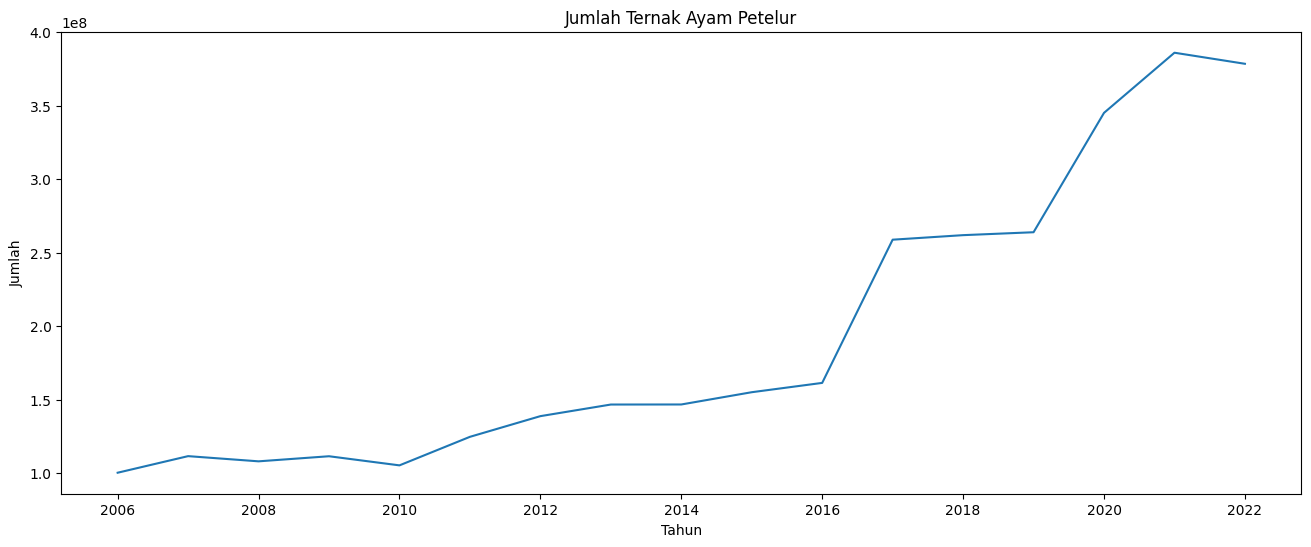

In [5]:
plt.figure(figsize=(16, 6))
plt.title("Jumlah Ternak Ayam Petelur")
plt.plot(df['Ayam Petelur'])
plt.xlabel('Tahun')
plt.ylabel('Jumlah')
plt.show()

In [6]:
dataset = df[['Ayam Petelur']]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.        ],
       [0.03947663],
       [0.02711773],
       [0.03922747],
       [0.0175169 ],
       [0.08545706],
       [0.13470773],
       [0.1623506 ],
       [0.16248665],
       [0.19167962],
       [0.21386179],
       [0.55483989],
       [0.56564326],
       [0.57258698],
       [0.85679945],
       [1.        ],
       [0.9736463 ]])

In [7]:
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

n_train = train_data.shape[0]
n_test = test_data.shape[0]

print("Jumlah data latih:", n_train)
print("Jumlah data uji:", n_test)

Jumlah data latih: 13
Jumlah data uji: 4


In [8]:
def create_dataset(data, time_steps=1):
    x, y = [], []
    for i in range(time_steps, len(data)):
        x.append(data[i-time_steps:i])
        y.append(data[i, 0])
    return np.array(x), np.array(y)

time_steps = 3
x_train, y_train = create_dataset(train_data, time_steps)
x_test, y_test = create_dataset(test_data, time_steps)

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [9]:
print(x_train.shape)
print(x_test.shape)

(10, 3, 1)
(1, 3, 1)


In [10]:
model = Sequential([
    LSTM(32, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    LSTM(16),
    Dense(8),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mape'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 32)             4352      
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 8)                 136       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 7633 (29.82 KB)
Trainable params: 7633 (29.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [13]:
history = model.fit(x_train, y_train, epochs=100, batch_size=2, validation_data=(x_test, y_test), callbacks=[early_stopping])

Epoch 1/100
5/5 [==============================] - 15s 483ms/step - loss: 0.0677 - mape: 81.3829 - val_loss: 0.7376 - val_mape: 88.2111
Epoch 2/100
5/5 [==============================] - 0s 38ms/step - loss: 0.0511 - mape: 71.6138 - val_loss: 0.6110 - val_mape: 80.2832
Epoch 3/100
5/5 [==============================] - 0s 32ms/step - loss: 0.0377 - mape: 106.5546 - val_loss: 0.4965 - val_mape: 72.3682
Epoch 4/100
5/5 [==============================] - 0s 22ms/step - loss: 0.0329 - mape: 133.5672 - val_loss: 0.3851 - val_mape: 63.7378
Epoch 5/100
5/5 [==============================] - 0s 28ms/step - loss: 0.0297 - mape: 173.2205 - val_loss: 0.2989 - val_mape: 56.1497
Epoch 6/100
5/5 [==============================] - 0s 20ms/step - loss: 0.0270 - mape: 202.8136 - val_loss: 0.2620 - val_mape: 52.5682
Epoch 7/100
5/5 [==============================] - 0s 23ms/step - loss: 0.0269 - mape: 207.5664 - val_loss: 0.2383 - val_mape: 50.1423
Epoch 8/100
5/5 [==============================] - 0s 2

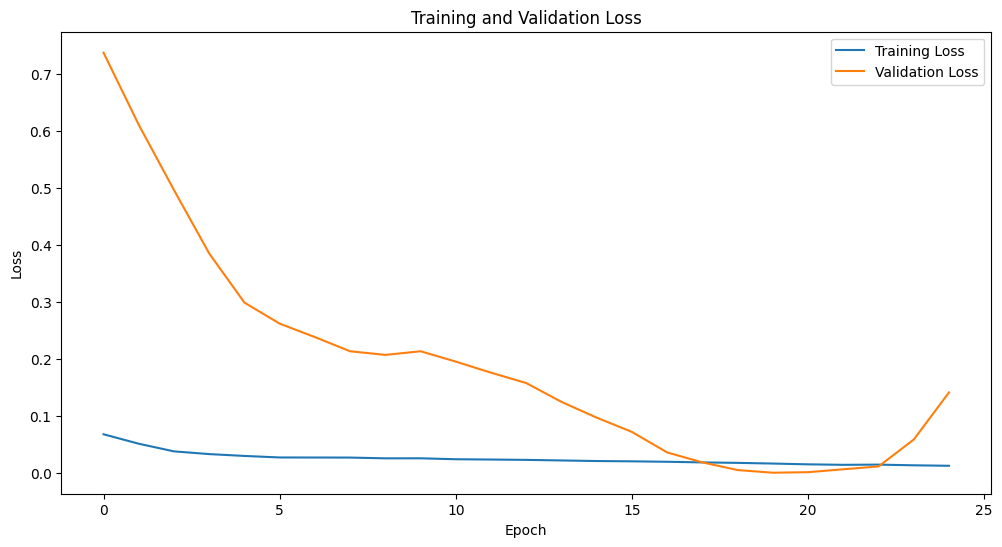

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
def predict_with_sliding_window(model, data, time_steps):
    predictions = []
    for i in range(time_steps, len(data)):
        x_input = data[i-time_steps:i].reshape((1, time_steps, 1))
        y_pred = model.predict(x_input)
        predictions.append(y_pred[0, 0])
    return np.array(predictions)

test_data_full = scaled_data[train_size-time_steps:]

predictions_full = predict_with_sliding_window(model, test_data_full, time_steps)
predictions_full = scaler.inverse_transform(predictions_full.reshape(-1, 1))

y_test_full = dataset['Ayam Petelur'].values[train_size:]

1/1 [==============================] - 0s 21ms/step


In [16]:
test_df_full = dataset.iloc[train_size:].copy()
test_df_full['Predictions'] = np.nan
test_df_full.iloc[:len(predictions_full), test_df_full.columns.get_loc('Predictions')] = predictions_full.flatten()
print("Data Test dengan Prediksi:")
print(test_df_full)

Data Test dengan Prediksi:
       Ayam Petelur  Predictions
Tahun                           
2019      263918004  251544288.0
2020      345181214  308502432.0
2021      386125709  328994496.0
2022      378590549  374281024.0


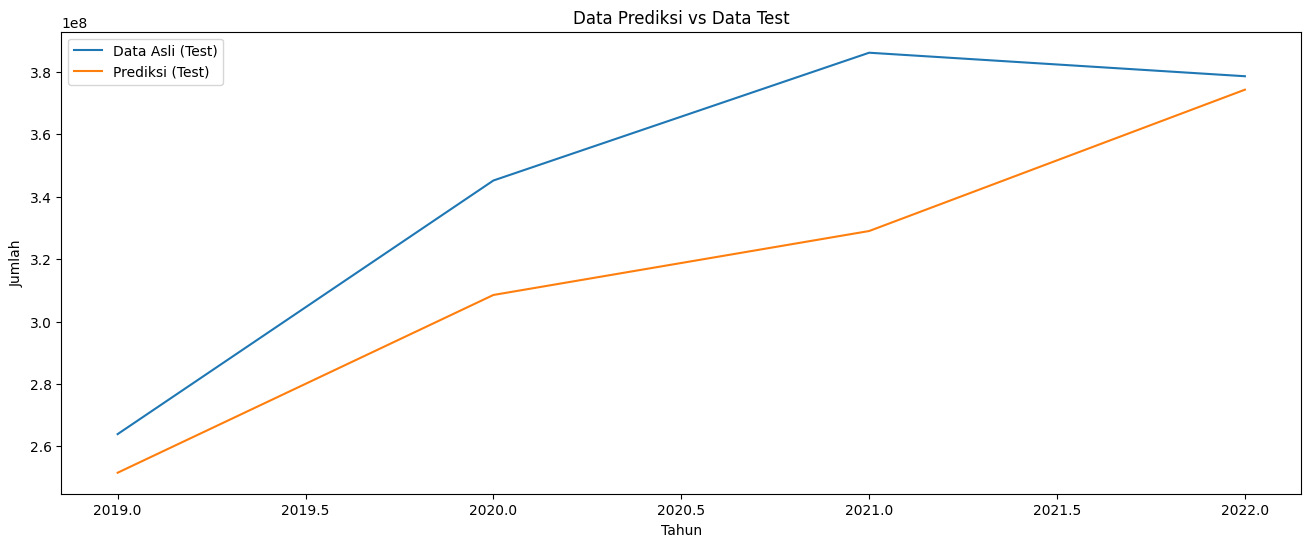

In [17]:
plt.figure(figsize=(16, 6))
plt.plot(dataset.index[train_size:], y_test_full, label='Data Asli (Test)')
plt.plot(dataset.index[train_size:], predictions_full, label='Prediksi (Test)')
plt.title('Data Prediksi vs Data Test')
plt.xlabel('Tahun')
plt.ylabel('Jumlah')
plt.legend()
plt.show()

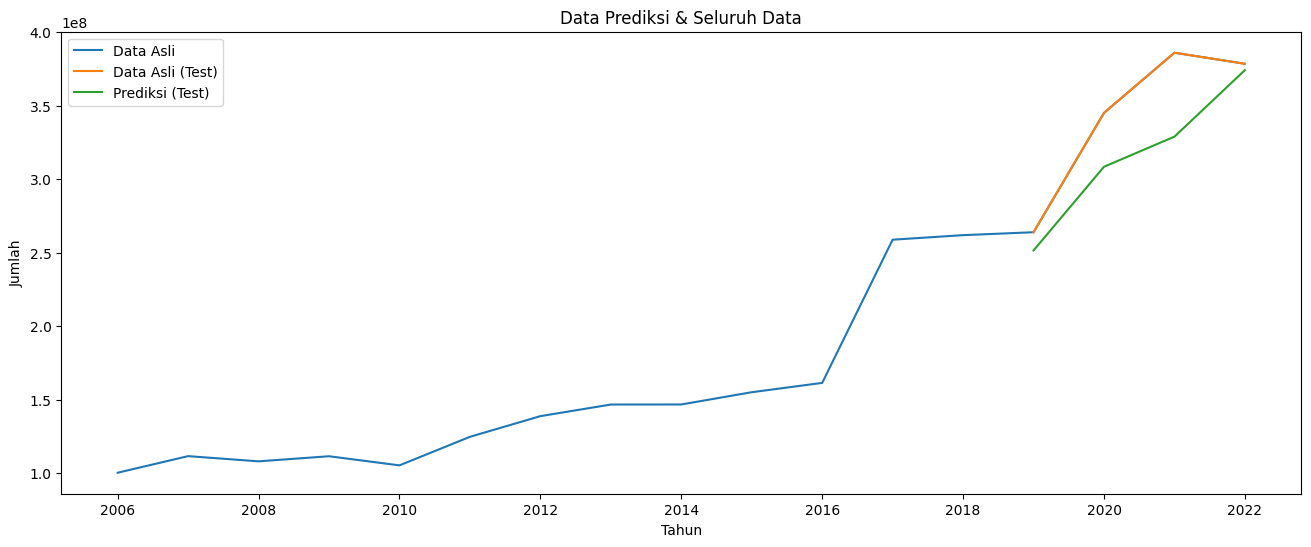

In [18]:
plt.figure(figsize=(16, 6))
plt.plot(dataset.index, dataset['Ayam Petelur'], label='Data Asli')
plt.plot(dataset.index[train_size:], y_test_full, label='Data Asli (Test)')
plt.plot(dataset.index[train_size:], predictions_full, label='Prediksi (Test)')
plt.title('Data Prediksi & Seluruh Data')
plt.xlabel('Tahun')
plt.ylabel('Jumlah')
plt.legend()
plt.show()

In [19]:
rmse = np.sqrt(mean_squared_error(y_test_full, predictions_full))
mape = mean_absolute_percentage_error(y_test_full, predictions_full.flatten()) * 100

print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

RMSE: 34572349.50516516
MAPE: 7.812185208834989


1/1 [==============================] - 0s 20ms/step
      Predicted_Jumlah
2023      4.414743e+08
2024      4.784339e+08
2025      5.095577e+08
2026      5.716259e+08
2027      6.198710e+08
2028      6.719503e+08
2029      7.334407e+08
2030      7.856964e+08
2031      8.367524e+08
2032      8.843674e+08
2033      9.230047e+08
2034      9.560402e+08
2035      9.828426e+08
2036      1.003302e+09
2037      1.019296e+09


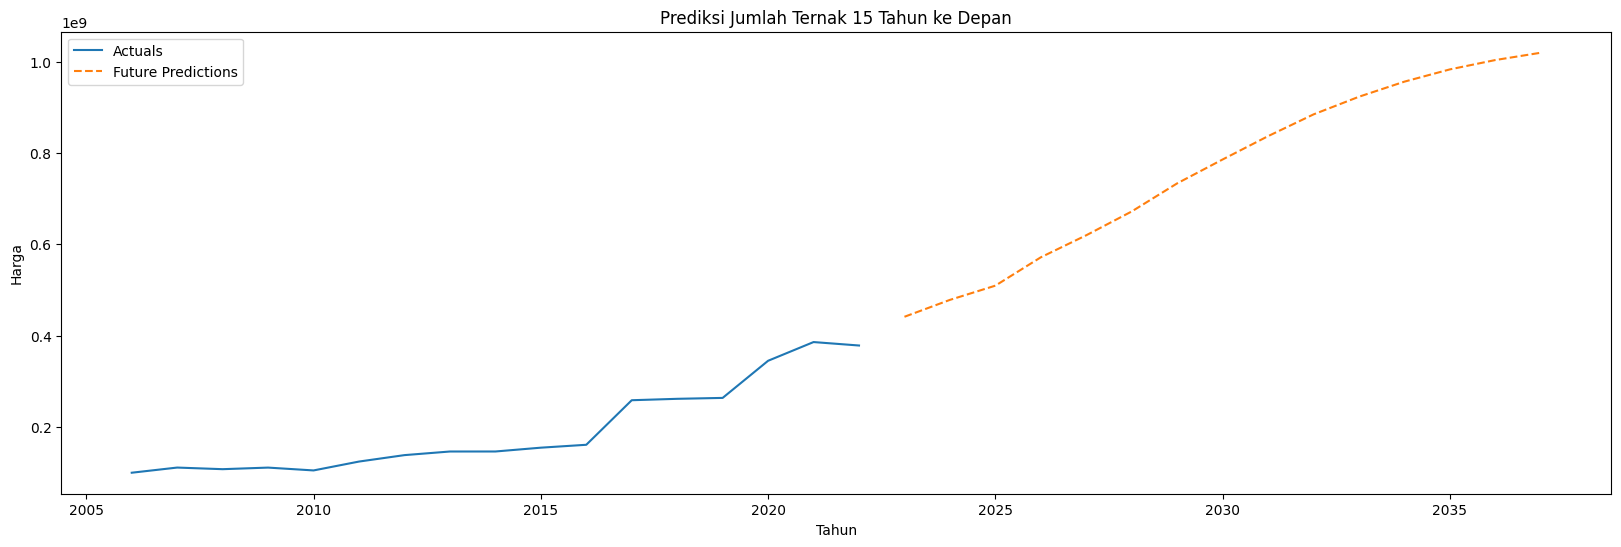

In [20]:
n_years = 15
last_data = scaled_data[-time_steps:]

future_predictions = []
for _ in range(n_years):
    pred = model.predict(last_data.reshape(1, time_steps, 1))
    future_predictions.append(pred[0, 0])
    last_data = np.append(last_data[1:], pred[0, 0]).reshape(time_steps, 1)

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

last_year = df.index[-1]
future_years = [last_year + i for i in range(1, n_years + 1)]
future_df = pd.DataFrame(data=future_predictions, index=future_years, columns=['Predicted_Jumlah'])

print(future_df)

plt.figure(figsize=(20, 6))
plt.plot(df['Ayam Petelur'], label='Actuals')
plt.plot(future_df['Predicted_Jumlah'], label='Future Predictions', linestyle='--')
plt.title(f'Prediksi Jumlah Ternak {n_years} Tahun ke Depan')
plt.xlabel('Tahun')
plt.ylabel('Harga')
plt.legend()
plt.show()